이 노트북은 [케라스 창시자에게 배우는 딥러닝 2판](https://tensorflow.blog/kerasdl2/)의 예제 코드를 담고 있습니다.

<table align="left">
    <tr>
        <td>
            <a href="https://colab.research.google.com/github/rickiepark/deep-learning-with-python-2nd/blob/main/chapter09_part03_interpreting-what-convnets-learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
        </td>
    </tr>
</table>

## 컨브넷이 학습한 것 해석하기

### 중간 활성화 시각화

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 이전 장에서 만든 "convnet_from_scratch_with_augmentation.keras" 파일을 업로드하세요.
from google.colab import files
files.upload()

# 또는 다음 코드의 주석을 제거하하고 깃허브에서 파일을 다운로드할 수 있습니다.
# !wget https://github.com/rickiepark/deep-learning-with-python-2nd/raw/main/convnet_from_scratch_with_augmentation.keras

In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/convnet_from_scratch_with_augmentation.keras")
model.summary()

**한 개의 이미지 전처리하기**

In [3]:
from tensorflow import keras
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg",
    origin="https://img-datasets.s3.amazonaws.com/cat.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(
        img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

80329/80329 [==============================] - 0s 0us/step


**테스트 이미지 출력하기**

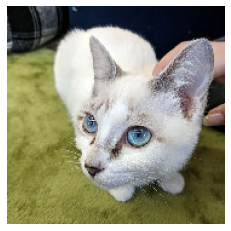

In [4]:
import matplotlib.pyplot as plt
plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

**층 활성화를 반환하는 모델 만들기**

In [5]:
from tensorflow.keras import layers

layer_outputs = []
layer_names = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPooling2D)):
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
        
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)

**층 활성화 계산하기**

In [6]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 7s 7s/step


In [7]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 178, 178, 32)


**다섯 번째 채널 시각화하기**

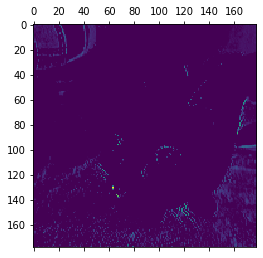

In [8]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 5], cmap="viridis")
plt.show()

**모든 층의 활성화에 있는 전체 채널 시각화하기**

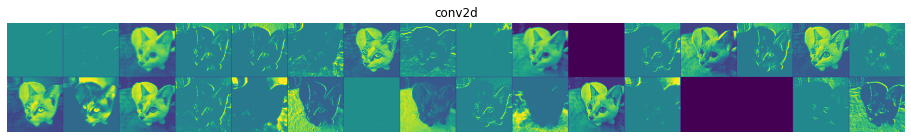

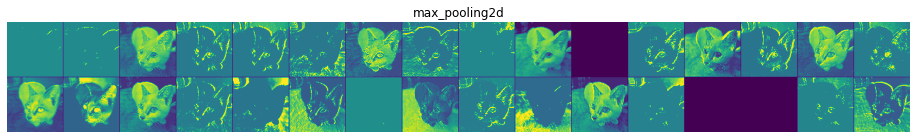

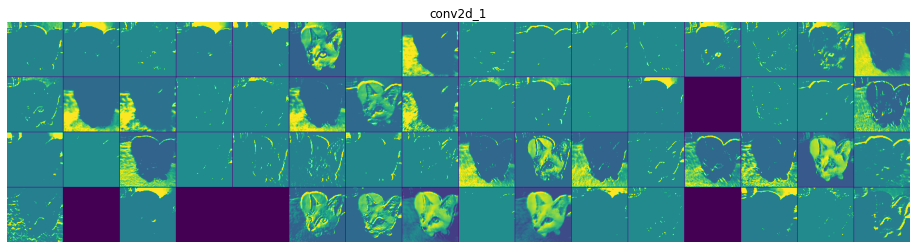

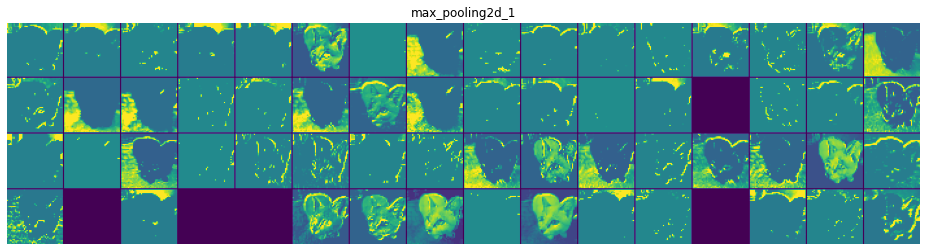

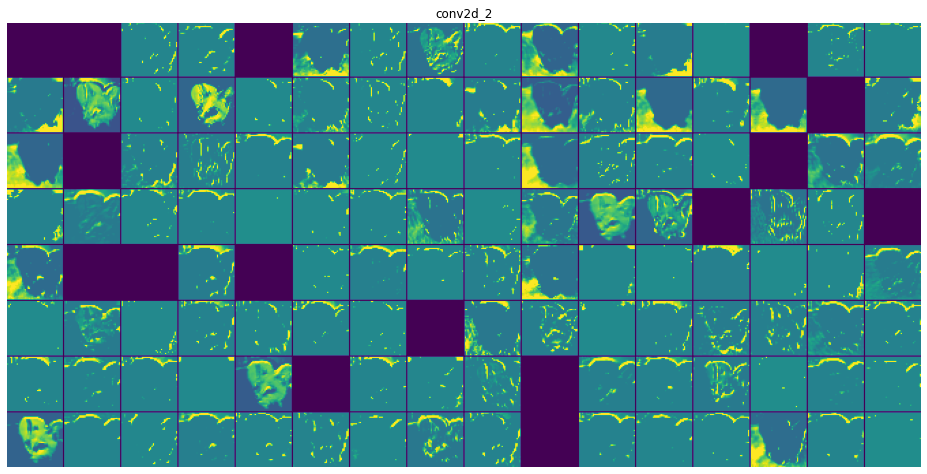

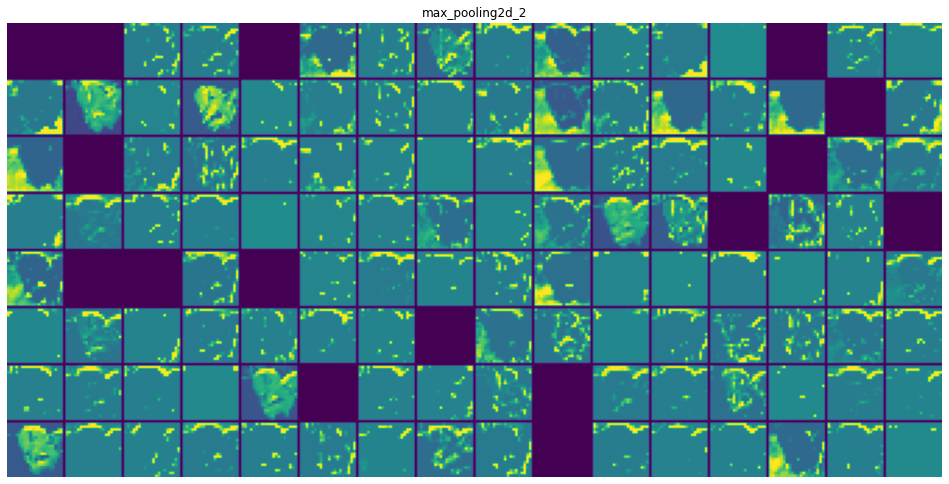

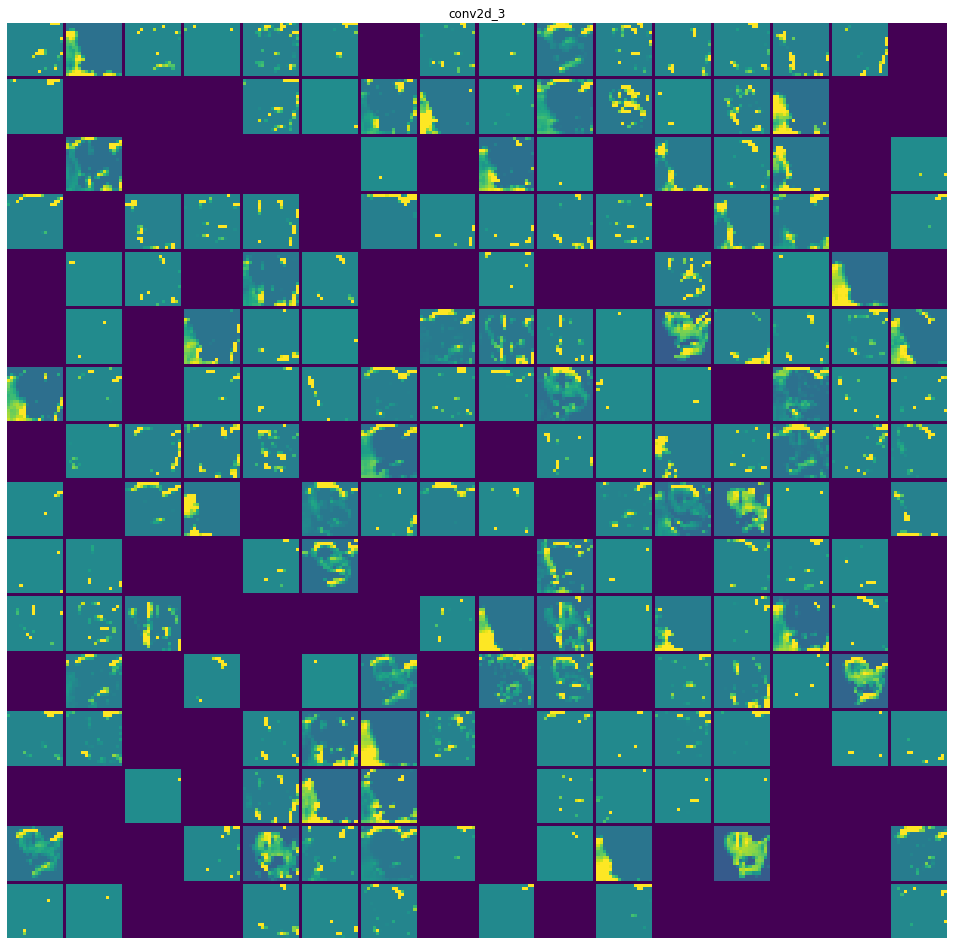

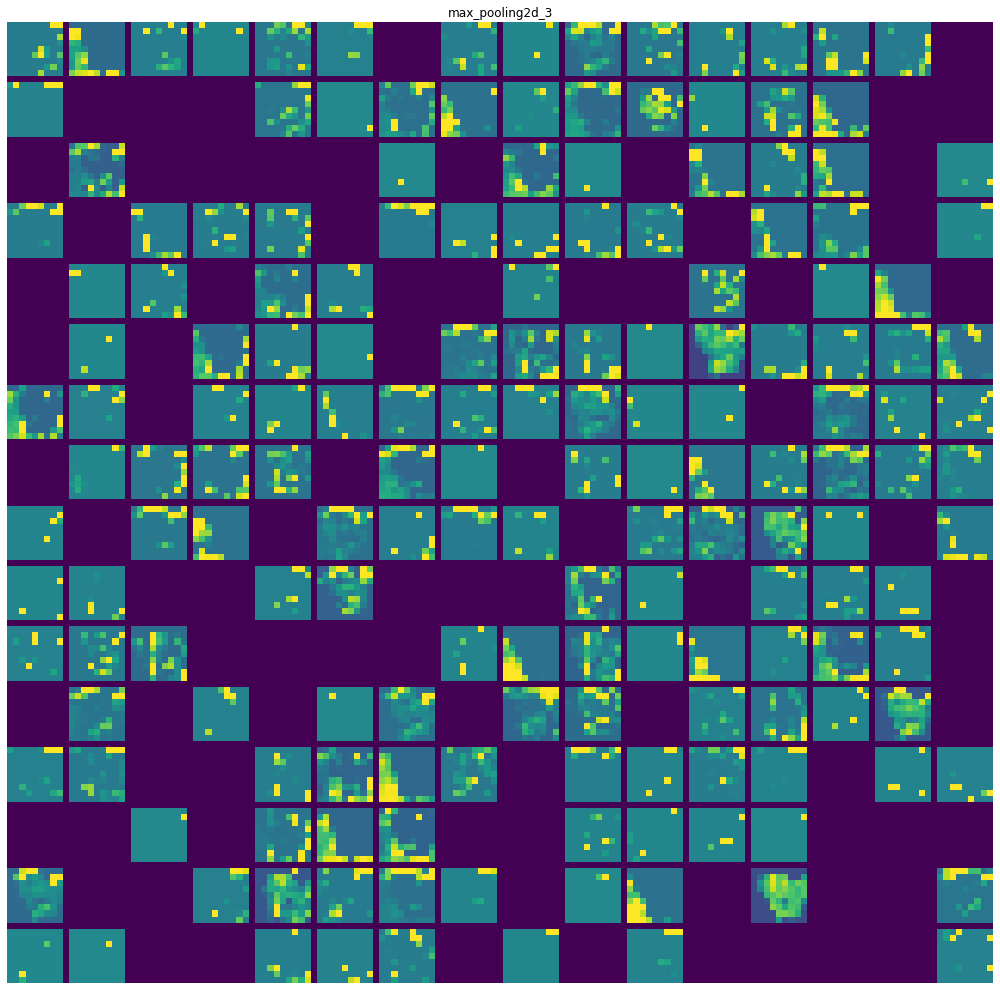

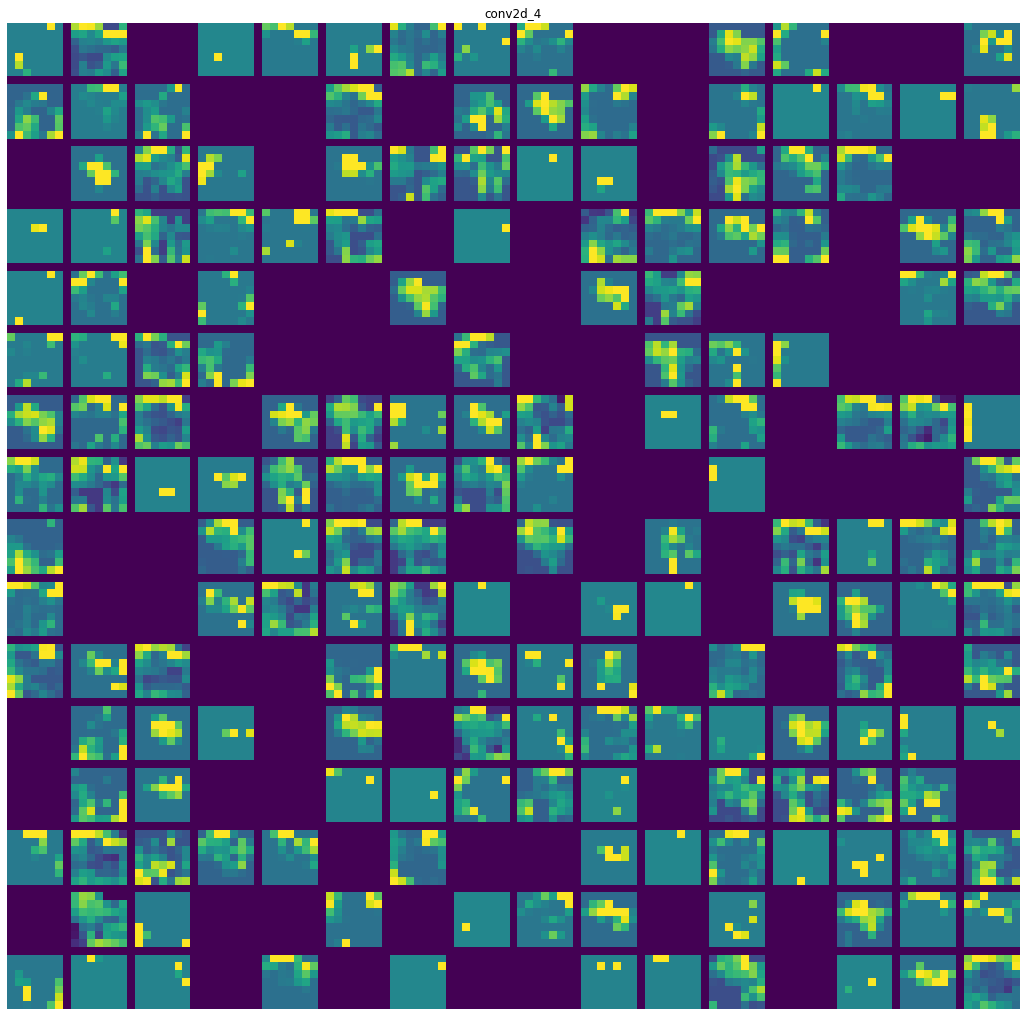

In [9]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros(((size + 1) * n_cols - 1,
                             images_per_row * (size + 1) - 1))
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_index = col * images_per_row + row
            channel_image = layer_activation[0, :, :, channel_index].copy()
            if channel_image.sum() != 0:
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * (size + 1): (col + 1) * size + col,
                row * (size + 1) : (row + 1) * size + row] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.axis("off")
    plt.imshow(display_grid, aspect="auto", cmap="viridis")

### 컨브넷 필터 시각화하기

**Xception 합성곱 기반 모델 만들기**

In [ ]:
model = keras.applications.xception.Xception(
    weights="imagenet",
    include_top=False)

83683744/83683744 [==============================] - 3s 0us/step


**Xception에 있는 모든 합성곱 층의 이름 출력하기**

In [ ]:
for layer in model.layers:
    if isinstance(layer, (keras.layers.Conv2D, keras.layers.SeparableConv2D)):
        print(layer.name)

block1_conv1
block1_conv2
block2_sepconv1
block2_sepconv2
conv2d
block3_sepconv1
block3_sepconv2
conv2d_1
block4_sepconv1
block4_sepconv2
conv2d_2
block5_sepconv1
block5_sepconv2
block5_sepconv3
block6_sepconv1
block6_sepconv2
block6_sepconv3
block7_sepconv1
block7_sepconv2
block7_sepconv3
block8_sepconv1
block8_sepconv2
block8_sepconv3
block9_sepconv1
block9_sepconv2
block9_sepconv3
block10_sepconv1
block10_sepconv2
block10_sepconv3
block11_sepconv1
block11_sepconv2
block11_sepconv3
block12_sepconv1
block12_sepconv2
block12_sepconv3
block13_sepconv1
block13_sepconv2
conv2d_3
block14_sepconv1
block14_sepconv2


**특성 추출 모델 만들기**

In [ ]:
layer_name = "block3_sepconv1"
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.input, outputs=layer.output)

**특성 추출 모델 사용하기**

In [ ]:
activation = feature_extractor(
    keras.applications.xception.preprocess_input(img_tensor)
)

In [ ]:
import tensorflow as tf

def compute_loss(image, filter_index):
    activation = feature_extractor(image)
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)

**확률적 경사 상승법을 사용한 손실 최대화**

In [ ]:
@tf.function
def gradient_ascent_step(image, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image, filter_index)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return image

**필터 시각화 생성 함수**

In [ ]:
img_width = 200
img_height = 200

def generate_filter_pattern(filter_index):
    iterations = 30
    learning_rate = 10.
    image = tf.random.uniform(
        minval=0.4,
        maxval=0.6,
        shape=(1, img_width, img_height, 3))
    for i in range(iterations):
        image = gradient_ascent_step(image, filter_index, learning_rate)
    return image[0].numpy()

**텐서를 이미지로 변환하기 위한 유틸리티 함수**

In [ ]:
def deprocess_image(image):
    image -= image.mean()
    image /= image.std()
    image *= 64
    image += 128
    image = np.clip(image, 0, 255).astype("uint8")
    image = image[25:-25, 25:-25, :]
    return image

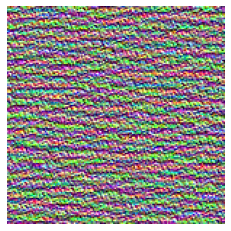

In [ ]:
plt.axis("off")
plt.imshow(deprocess_image(generate_filter_pattern(filter_index=2)))
plt.show()

**층에 있는 모든 필터의 응답 패턴에 대한 그리드 생성하기**

In [ ]:
all_images = []
for filter_index in range(64):
    print(f"{filter_index}번 필터 처리중")
    image = deprocess_image(
        generate_filter_pattern(filter_index)
    )
    all_images.append(image)

margin = 5
n = 8
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

for i in range(n):
    for j in range(n):
        image = all_images[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = image

keras.utils.save_img(
    f"filters_for_layer_{layer_name}.png", stitched_filters)

0번 필터 처리중
1번 필터 처리중
2번 필터 처리중
3번 필터 처리중
4번 필터 처리중
5번 필터 처리중
6번 필터 처리중
7번 필터 처리중
8번 필터 처리중
9번 필터 처리중
10번 필터 처리중
11번 필터 처리중
12번 필터 처리중
13번 필터 처리중
14번 필터 처리중
15번 필터 처리중
16번 필터 처리중
17번 필터 처리중
18번 필터 처리중
19번 필터 처리중
20번 필터 처리중
21번 필터 처리중
22번 필터 처리중
23번 필터 처리중
24번 필터 처리중
25번 필터 처리중
26번 필터 처리중
27번 필터 처리중
28번 필터 처리중
29번 필터 처리중
30번 필터 처리중
31번 필터 처리중
32번 필터 처리중
33번 필터 처리중
34번 필터 처리중
35번 필터 처리중
36번 필터 처리중
37번 필터 처리중
38번 필터 처리중
39번 필터 처리중
40번 필터 처리중
41번 필터 처리중
42번 필터 처리중
43번 필터 처리중
44번 필터 처리중
45번 필터 처리중
46번 필터 처리중
47번 필터 처리중
48번 필터 처리중
49번 필터 처리중
50번 필터 처리중
51번 필터 처리중
52번 필터 처리중
53번 필터 처리중
54번 필터 처리중
55번 필터 처리중
56번 필터 처리중
57번 필터 처리중
58번 필터 처리중
59번 필터 처리중
60번 필터 처리중
61번 필터 처리중
62번 필터 처리중
63번 필터 처리중


In [ ]:
from IPython.display import Image

Image(f"filters_for_layer_{layer_name}.png")

Output hidden; open in https://colab.research.google.com to view.

### 클래스 활성화의 히트맵 시각화하기

**사전 훈련된 가중치로 Xception 네트워크 로드하기**

In [ ]:
model = keras.applications.xception.Xception(weights="imagenet")

91884032/91884032 [==============================] - 4s 0us/step


**Xception 모델에 맞게 입력 이미지를 전처리하기**

In [ ]:
img_path = keras.utils.get_file(
    fname="elephant.jpg",
    origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = keras.applications.xception.preprocess_input(array)
    return array

img_array = get_img_array(img_path, target_size=(299, 299))

733657/733657 [==============================] - 0s 1us/step


In [ ]:
preds = model.predict(img_array)
print(keras.applications.xception.decode_predictions(preds, top=3)[0])

35363/35363 [==============================] - 0s 0us/step
[('n02504458', 'African_elephant', 0.8699264), ('n01871265', 'tusker', 0.07696874), ('n02504013', 'Indian_elephant', 0.023537323)]


In [ ]:
np.argmax(preds[0])

386

**마지막 합성곱 출력을 반환하는 모델 만들기**

In [ ]:
last_conv_layer_name = "block14_sepconv2_act"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]
last_conv_layer = model.get_layer(last_conv_layer_name)
last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

**마지막 합성곱 출력 위에 있는 분류기에 적용하기 위한 모델 만들기**

In [ ]:
classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    x = model.get_layer(layer_name)(x)
classifier_model = keras.Model(classifier_input, x)

**최상위 예측 클래스의 그레이디언트 계산하기**

In [ ]:
import tensorflow as tf

with tf.GradientTape() as tape:
    last_conv_layer_output = last_conv_layer_model(img_array)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

**그레이디언트를 평균하고 채널 중요도 가중치 적용하기**

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
heatmap = np.mean(last_conv_layer_output, axis=-1)

**히트맵 후처리하기**

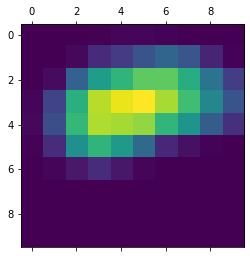

In [ ]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

**원본 이미지 위에 히트맵 그리기**

In [ ]:
import matplotlib.cm as cm

img = keras.utils.load_img(img_path)
img = keras.utils.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.utils.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.utils.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.utils.array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

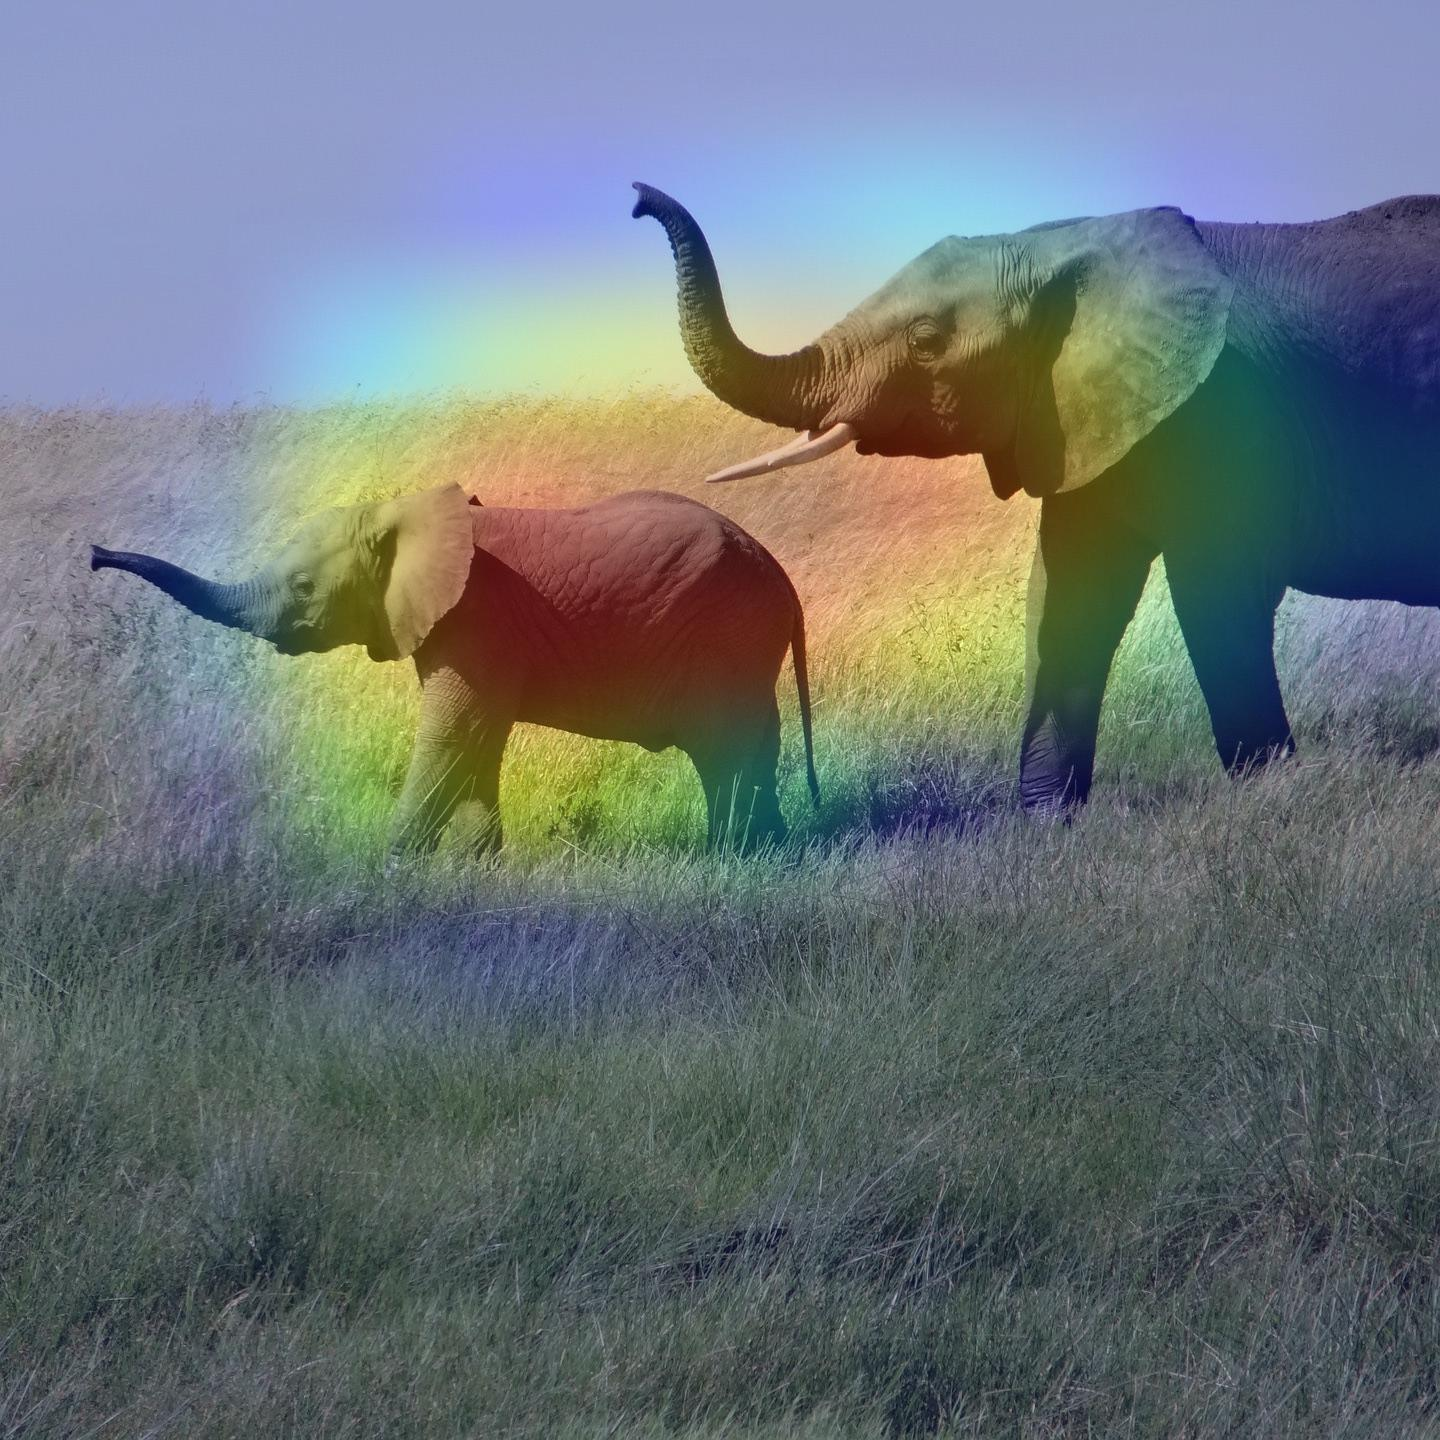

In [ ]:
Image("elephant_cam.jpg")

## 요약